# Input variables:
   ### Bank Client data:
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   ### Related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   ### Other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
   ### Social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  ### Output variable (desired target):
  
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

### Importing all the necessary libraries

In [36]:
import pandas as pd
pd.set_option ( "display.max_rows" , None )
pd.set_option ( "display.max_columns" , None )
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings ( "ignore" )

### Loading the dataset

In [2]:
data = pd.read_csv ( "bank-additional-full.csv" , sep = ";" )
data.head ( )

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Information about the dataset

In [3]:
# Number of Records and Features
print ( "Rows:" , data.shape [ 0 ] )
print ( "Features:" , data.shape [ 1 ] )

Rows: 41188
Features: 21


In [4]:
# Feature names with their data types and null values (if any)
pd.DataFrame ( { "Feature" : data.columns , "Data Type" : list ( data.dtypes ) , 
               "Null Values" : list ( data.isnull ( ).sum ( ) ) } )

,Feature,Data Type,Null Values
0,age,int64,0
1,job,object,0
2,marital,object,0
3,education,object,0
4,default,object,0
5,housing,object,0
6,loan,object,0
7,contact,object,0
8,month,object,0
9,day_of_week,object,0


In [5]:
# Splitting continuous and categorical feature names
categorical = data.select_dtypes ( include = "O" ).columns
continuous = data.select_dtypes ( exclude = "O" ).columns

In [6]:
# Description of categorical features
data [ categorical ].describe ( )

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [7]:
# Description of continuous features
data [ continuous ].describe ( )

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Univariate Analysis

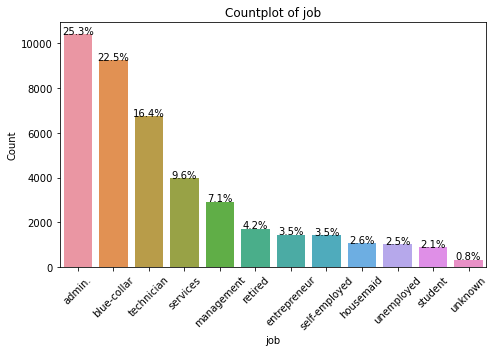

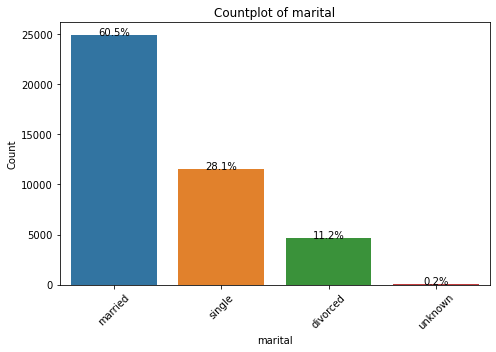

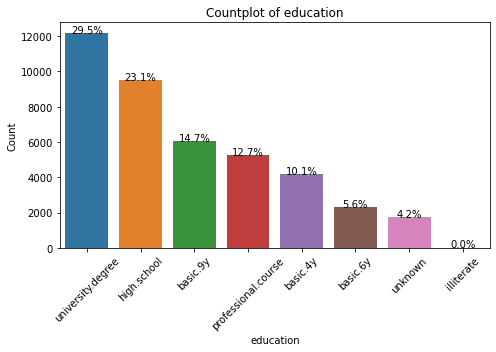

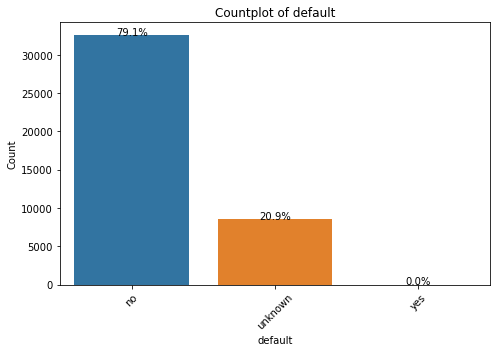

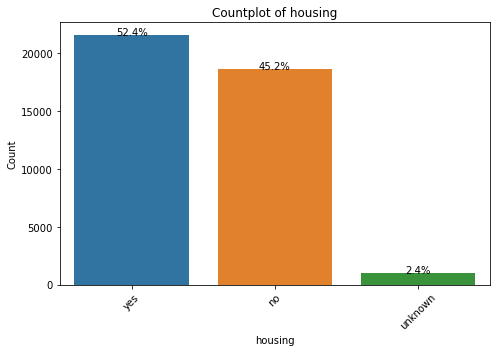

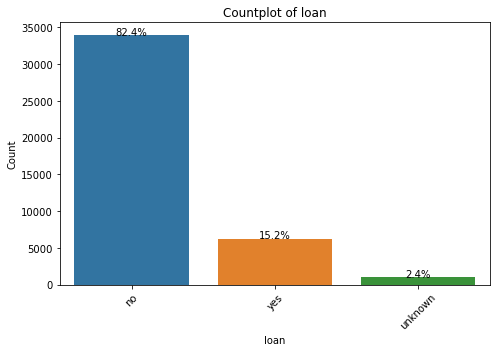

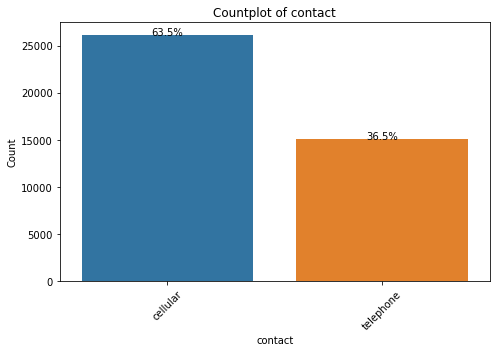

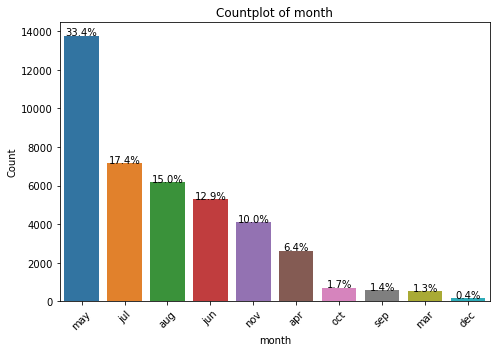

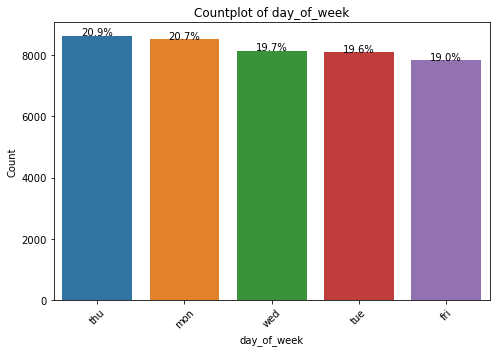

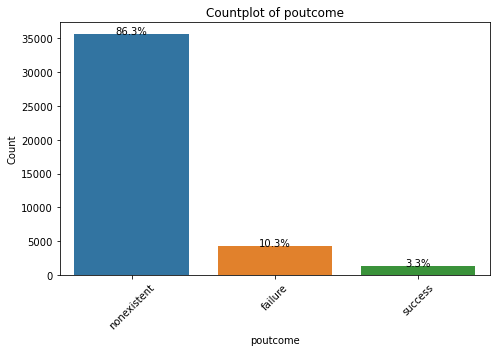

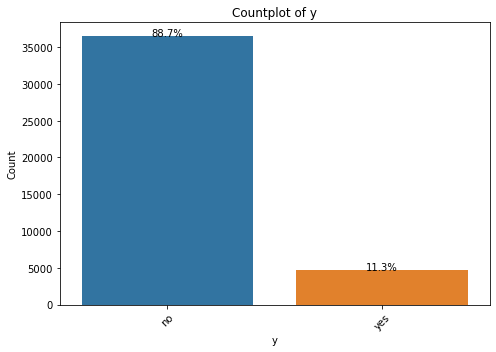

In [8]:
# Understanding the categorical variables
for feature in categorical:
    plt.rcParams [ "figure.figsize" ] = [ 7 , 5 ]
    plt.rcParams [ "figure.autolayout" ] = True

    counts = data [ feature ].value_counts ( )
    ax = sns.barplot ( x = counts.index  , y = list ( counts ) )
    percentage = list ( np.array ( list ( counts ) ) / data.shape [ 0 ] * 100 )
    patches = ax.patches
    for i in range ( len ( patches ) ):
        x = patches [ i ].get_x ( ) + patches [ i ].get_width ( ) / 2
        y = patches [ i ].get_height ( ) + 0.05
        ax.annotate ( '{:.1f}%' .format ( percentage [ i ] ) 
                     , ( x , y ) , ha = 'center' )
    plt.title ( "Countplot of " + feature )
    plt.xlabel ( feature )
    plt.ylabel ( "Count" )
    plt.xticks ( rotation = 45 )
    plt.show()

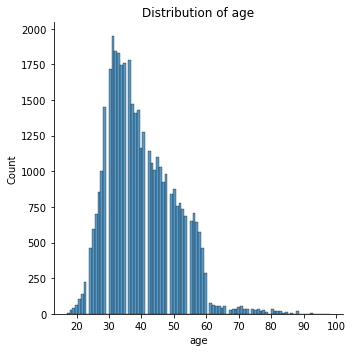

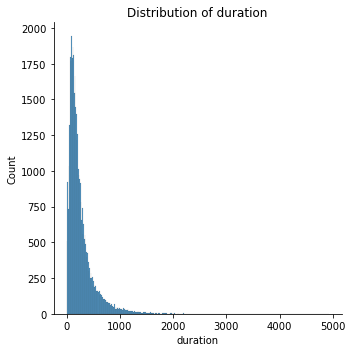

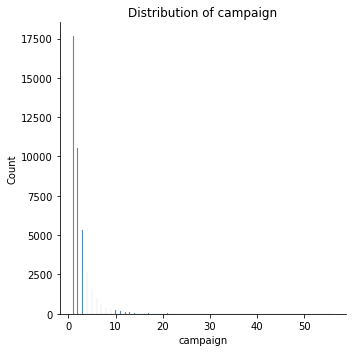

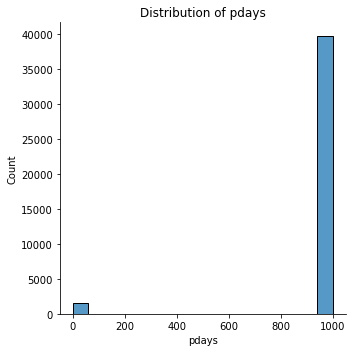

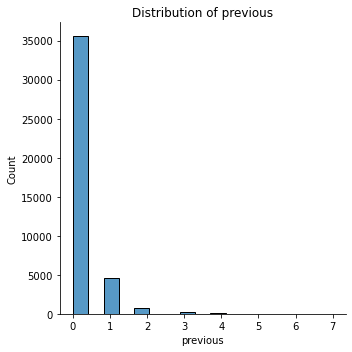

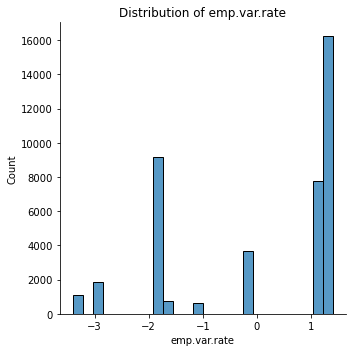

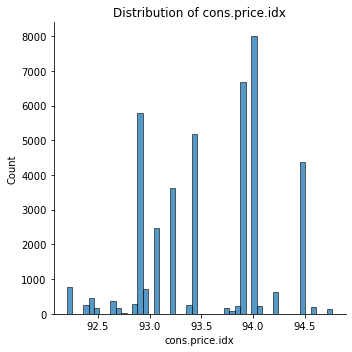

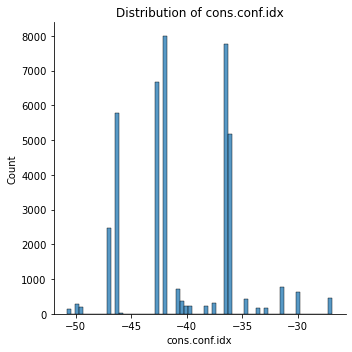

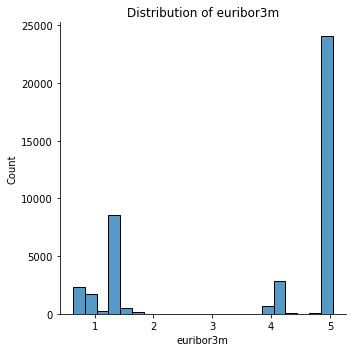

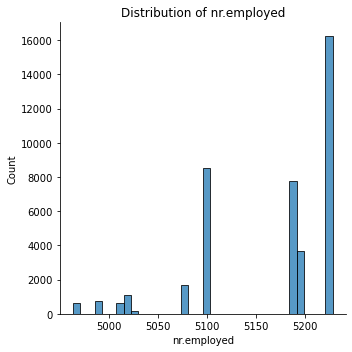

In [9]:
# Understanding the continuous variable
for feature in continuous:
    sns.displot ( data [ feature ] )
    plt.title ( "Distribution of " + feature )
    plt.show ( )

### Feature comparison with respect to target variable "y"

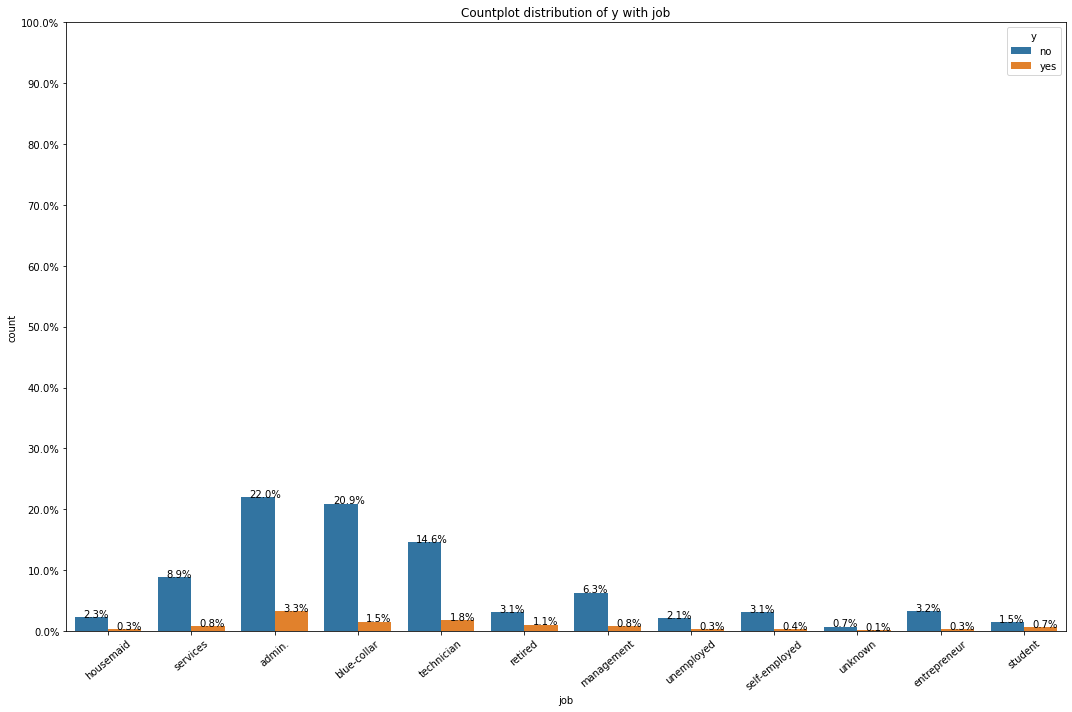

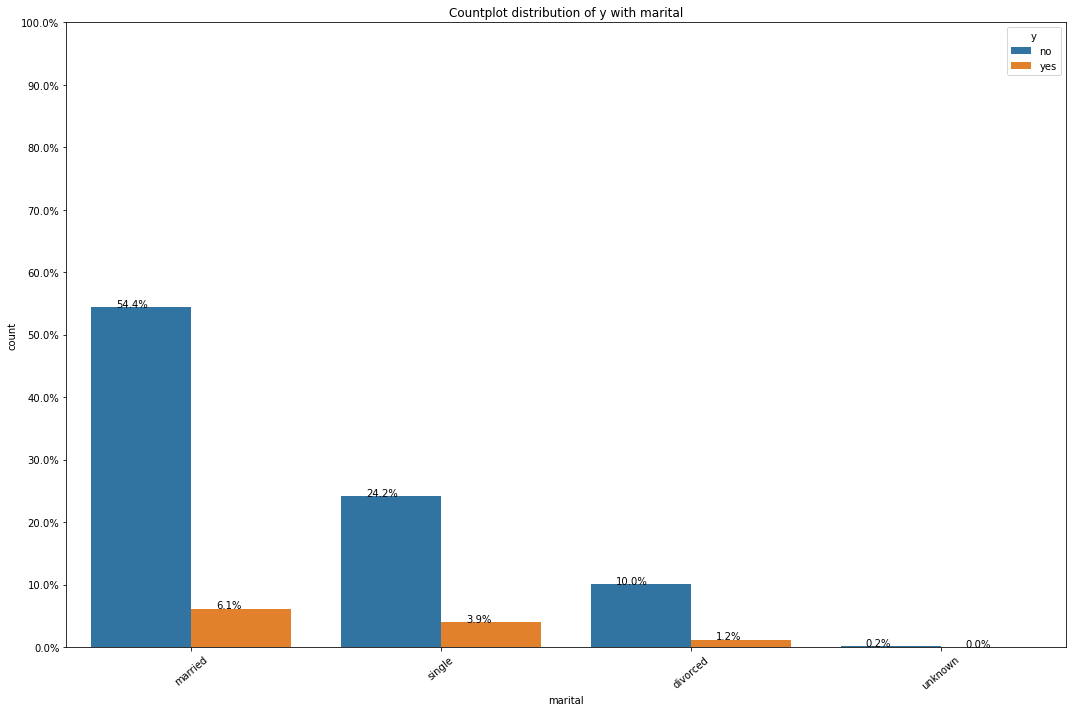

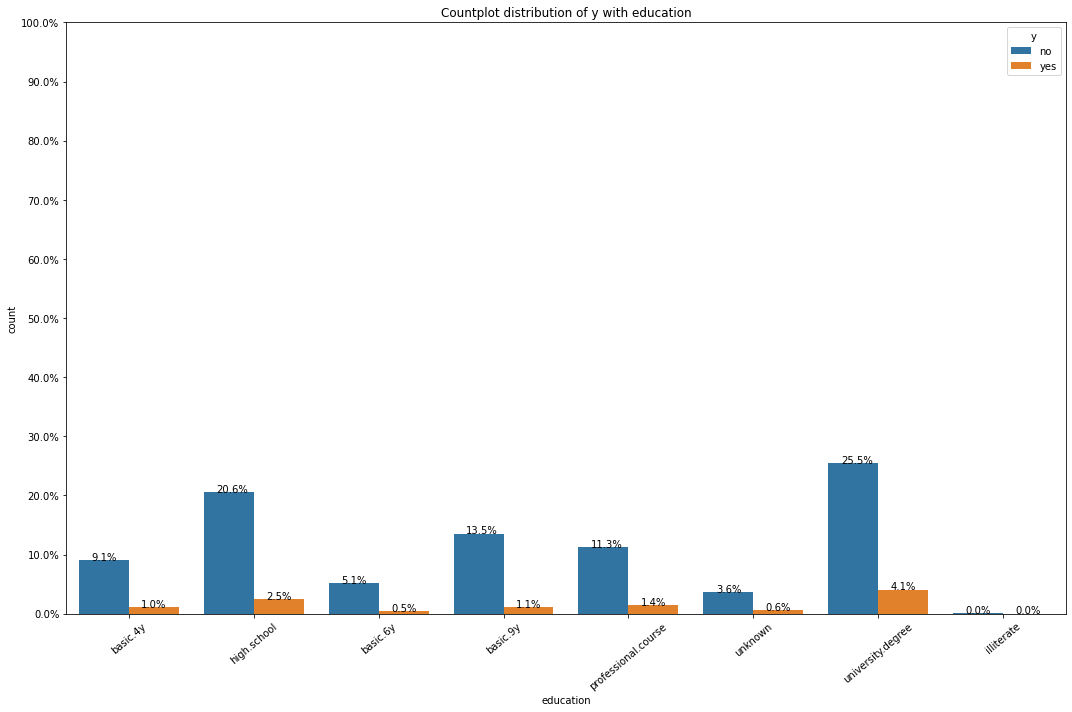

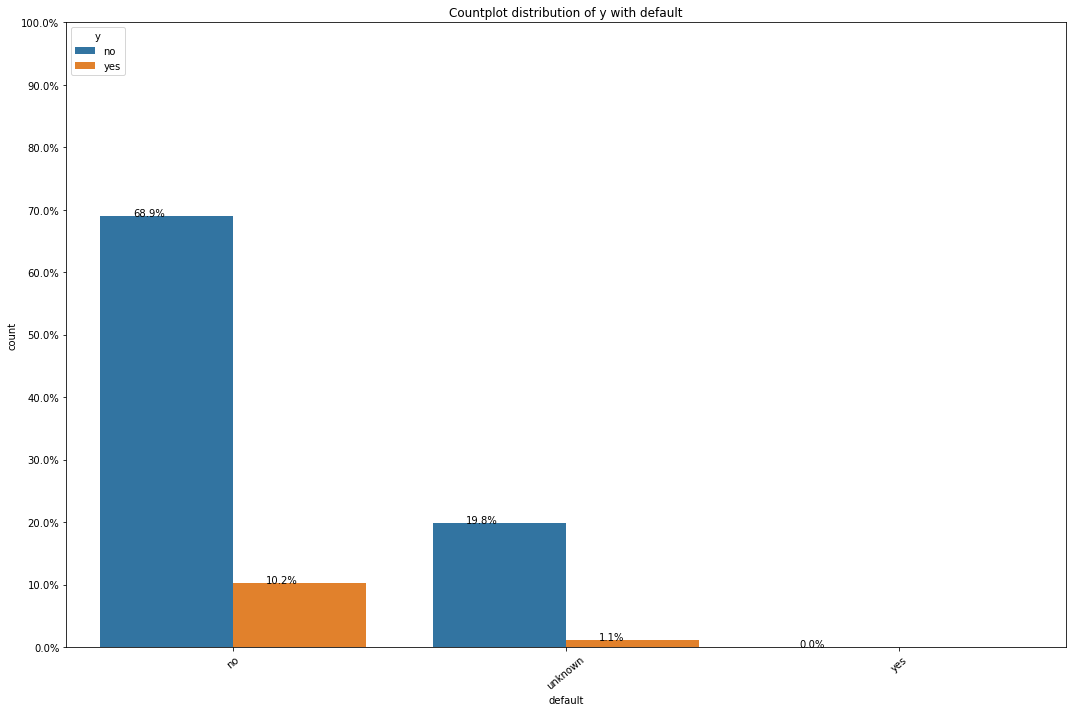

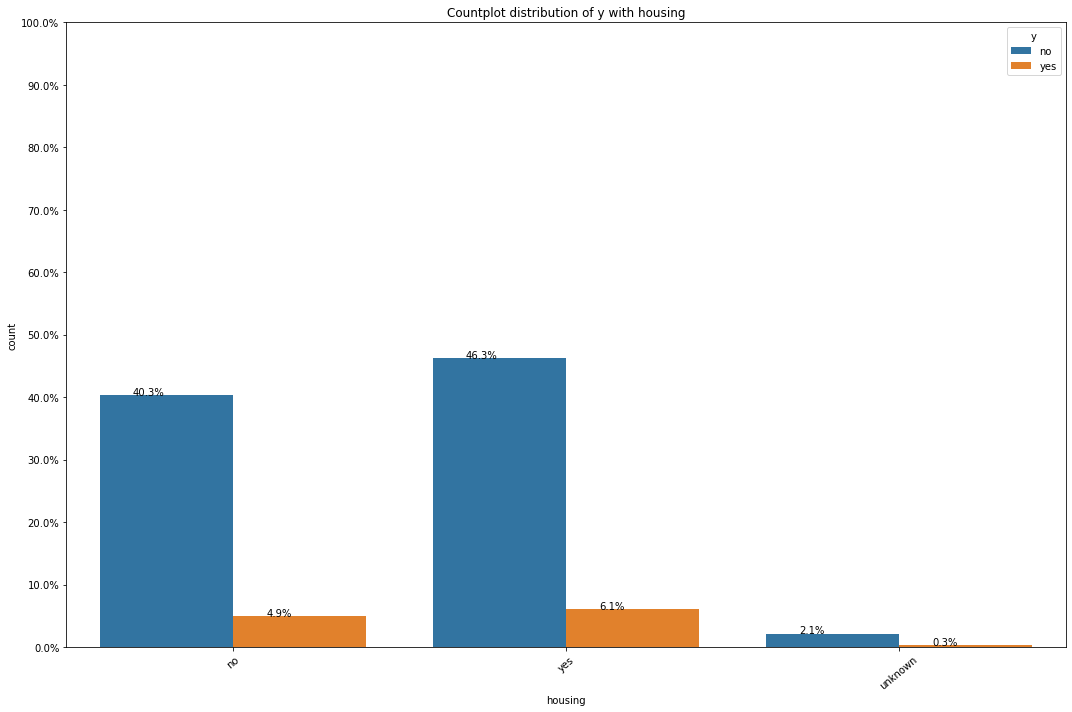

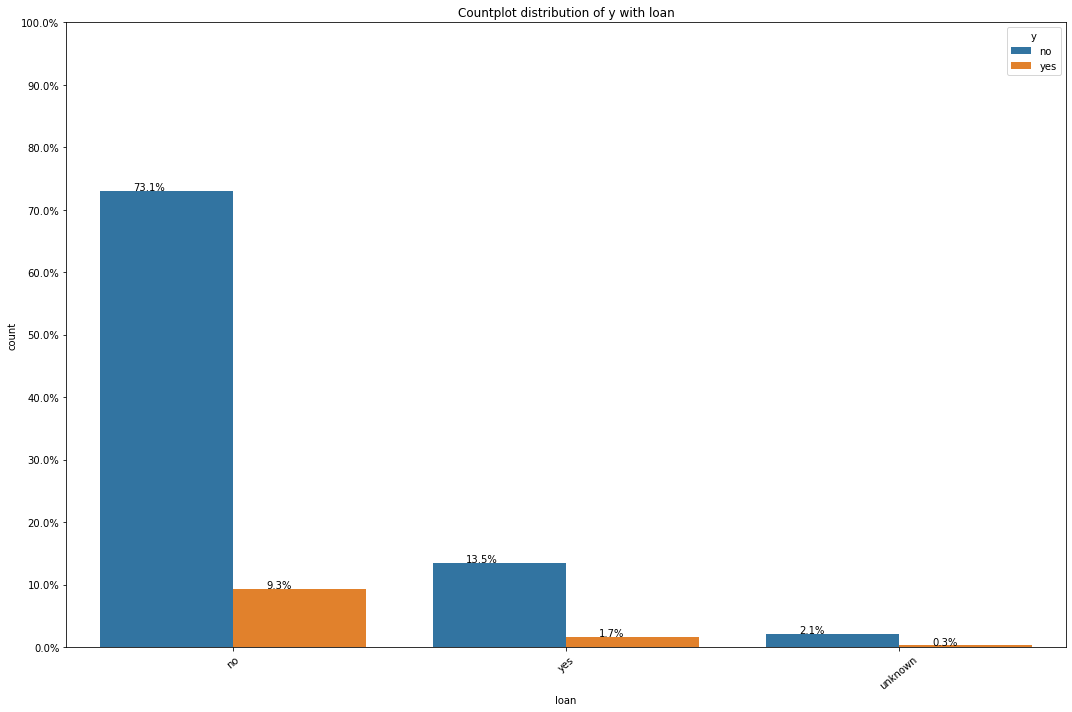

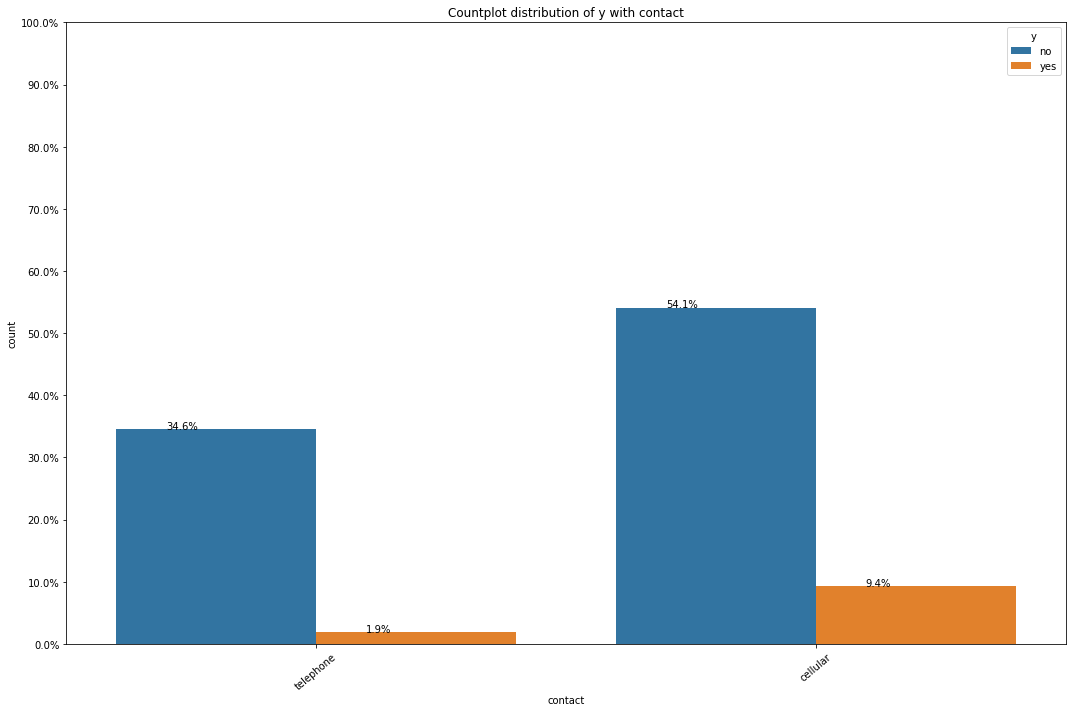

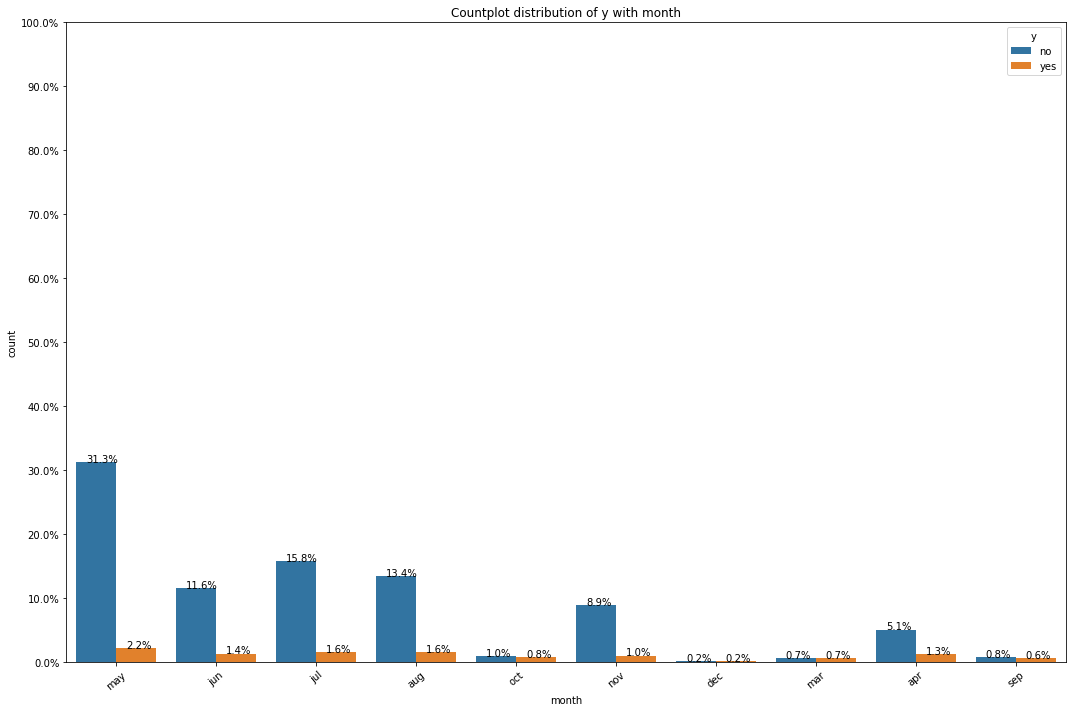

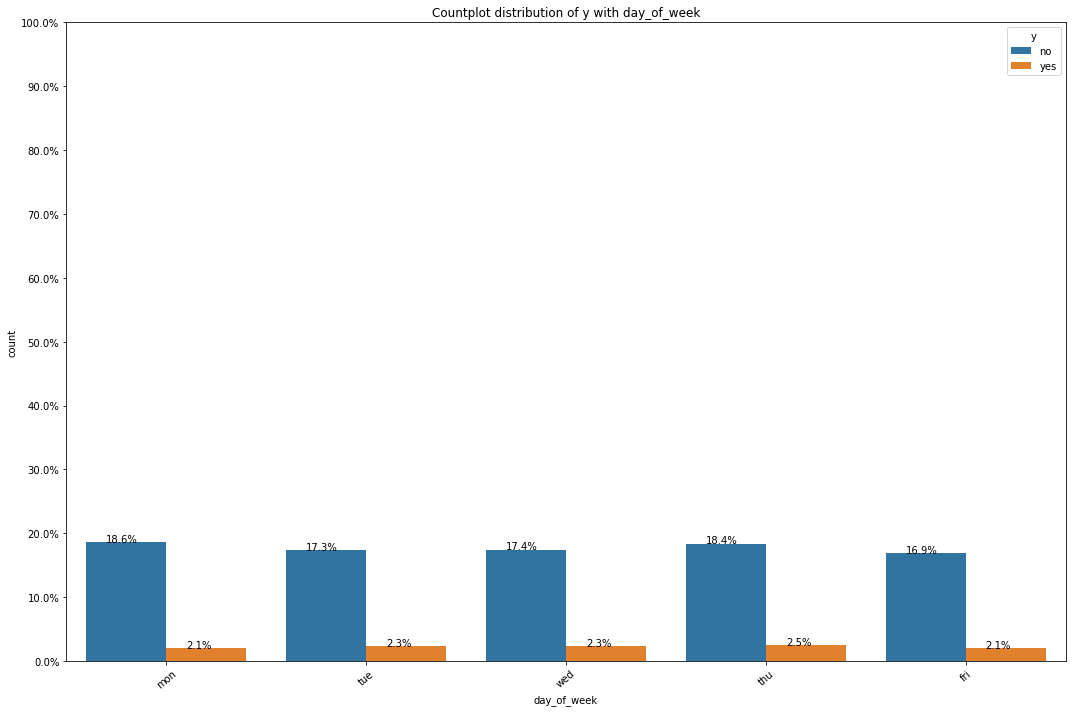

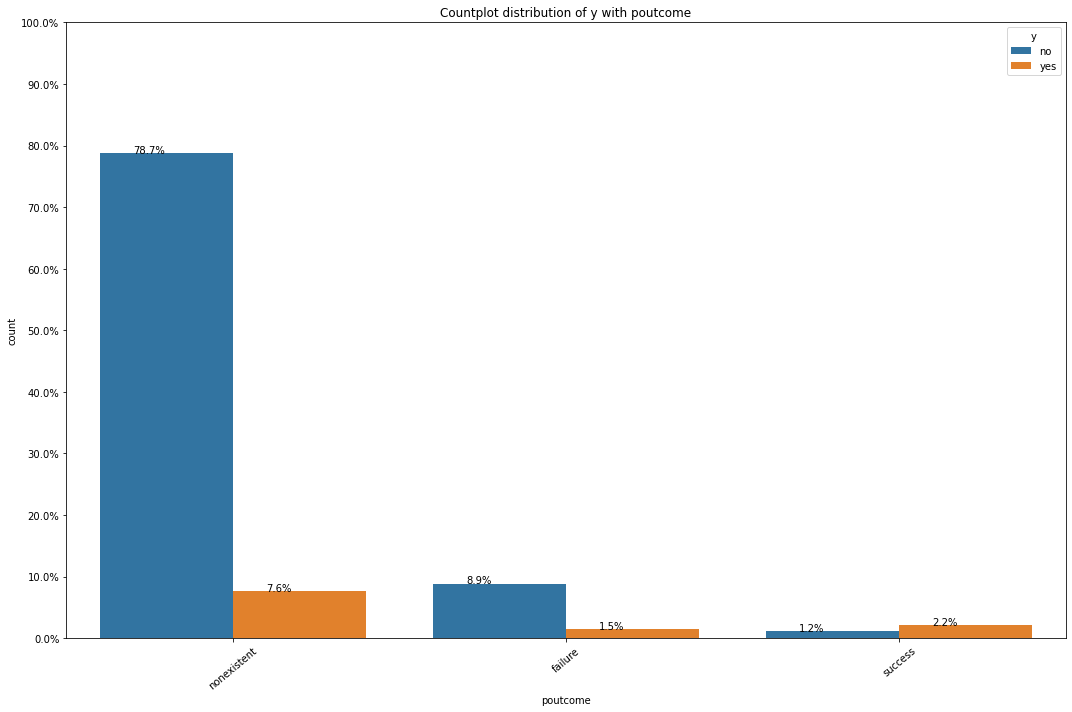

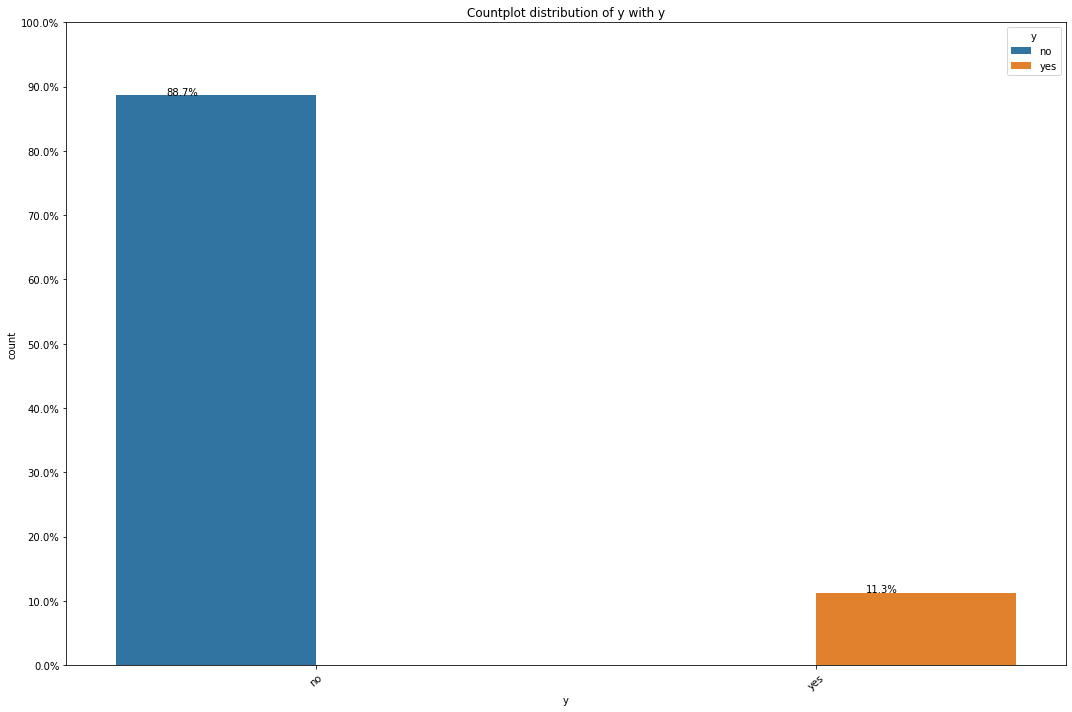

In [10]:
for feature in categorical:
    plt.figure ( figsize = ( 15 , 10 ) )
    Y = data [ feature ]
    total = len ( Y ) * 1.
    ax = sns.countplot ( x = feature , data = data , hue = "y" )
    for p in ax.patches:
        ax.annotate ( '{:.1f}%' .format ( 100*p.get_height ( ) / total ) , 
                     ( p.get_x ( ) + 0.1 , p.get_height ( ) + 5 ) )
    ax.yaxis.set_ticks ( np.linspace ( 0 , total , 11 ) )
    ax.set_yticklabels ( map ( '{:.1f}%' .format , 100 * ax.yaxis.get_majorticklocs ( ) / total ) )
    ax.set_xticklabels ( ax.get_xticklabels ( ) , rotation = 40 , ha = "center" )
    plt.title ( "Countplot distribution of y with " + feature )
    plt.show ( )

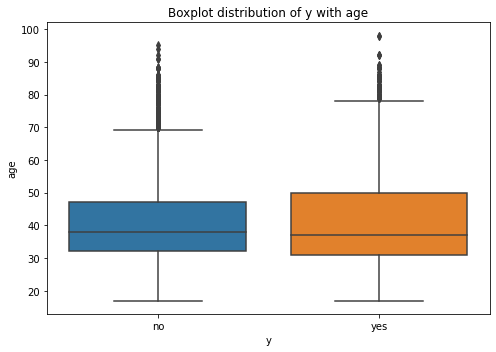

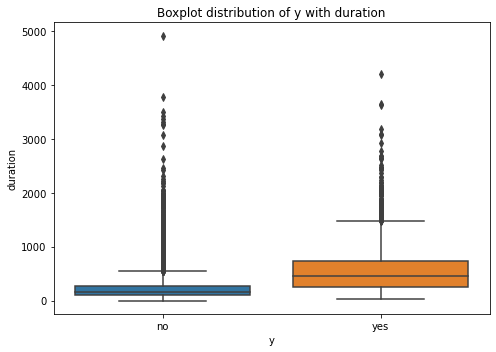

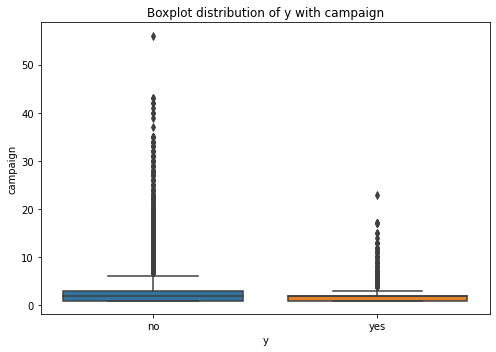

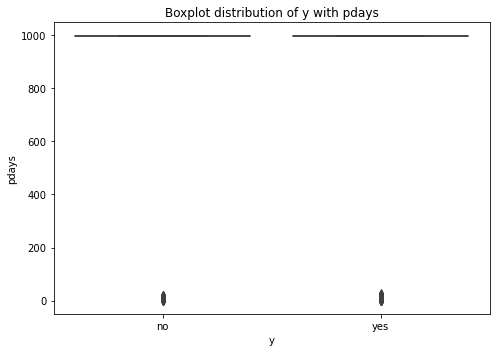

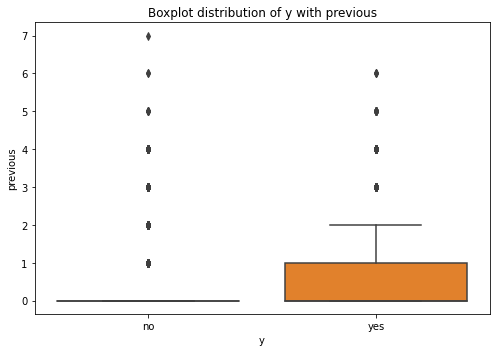

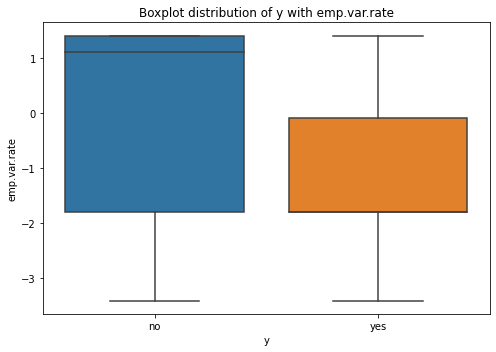

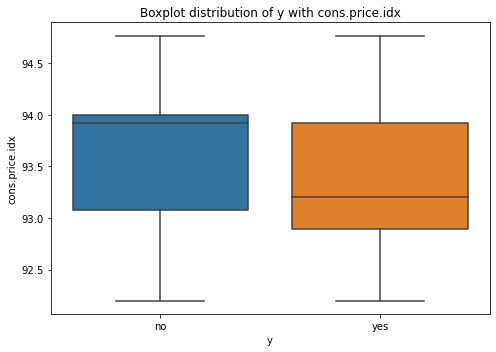

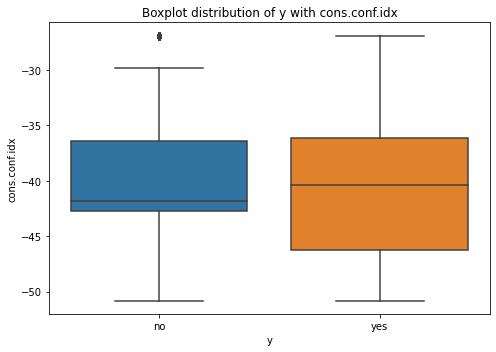

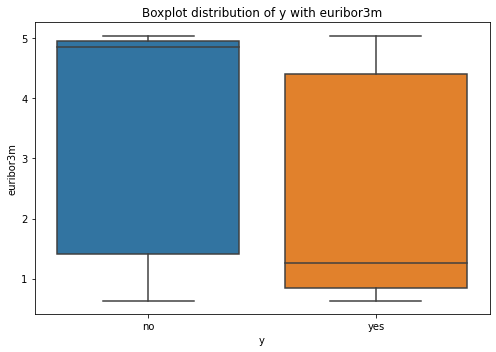

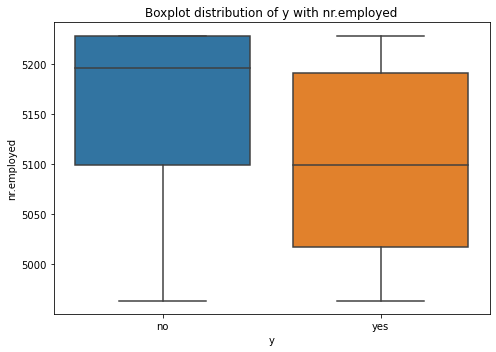

In [11]:
for feature in continuous:
    sns.boxplot ( y = data [ feature ] , x = data [ "y" ] )
    plt.title ( "Boxplot distribution of y with " + feature )
    plt.show ( )

### Correlation Matrix

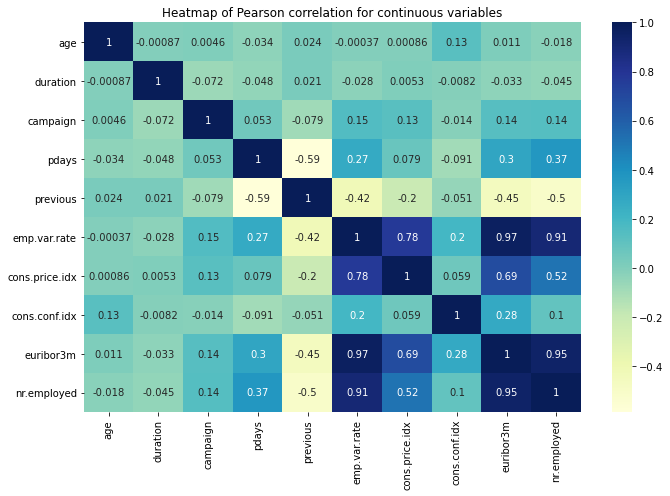

In [12]:
# Finding Pearson correlation for continuous variables
plt.figure ( figsize = ( 10 , 7 ) )
sns.heatmap ( data [ continuous ].corr ( method = "pearson" ) , annot = True , cmap = "YlGnBu" )
plt.title ( "Heatmap of Pearson correlation for continuous variables" )
plt.show ( )

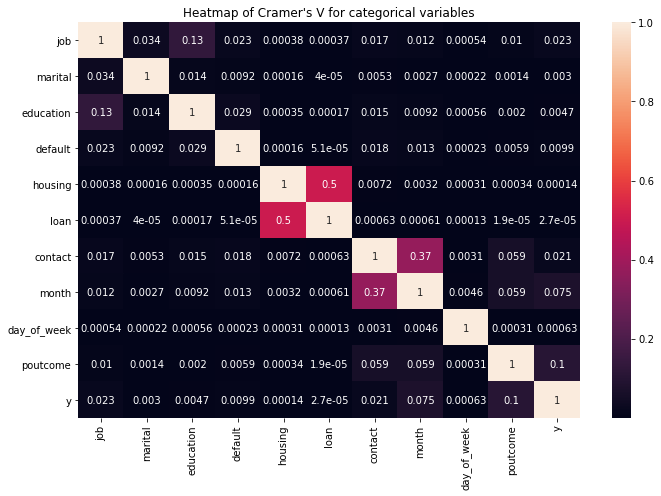

In [13]:
# Finding Cramer's V for categorical variables
def cramers_V ( feature1 , feature2 ):
    crosstab = pd.crosstab ( feature1 , feature2 )
    chi2_statistic = chi2_contingency ( crosstab ) [ 0 ]
    obs = sum ( np.sum ( crosstab ) )
    minimum = min ( crosstab.shape ) - 1 
    return ( chi2_statistic / ( obs * minimum ) )

columns = [ ]
for feature1 in data [ categorical ]:
    rows = [ ]
    for feature2 in data [ categorical ]:
        cramers = cramers_V ( data [ feature1 ] , data [ feature2 ] )
        rows.append ( cramers )
    columns.append ( rows )
results = np.array ( columns )
df = pd.DataFrame ( index = data [ categorical ].columns , columns = data [ categorical ].columns , 
                  data = results )

plt.figure ( figsize = ( 10 , 7 ) )
sns.heatmap ( df , annot = True )
plt.title ( "Heatmap of Cramer's V for categorical variables" )
plt.show ( )

### Pre-Processing

In [14]:
# Finding redundant data
print ( "Duplicate rows: " , data [ data.duplicated ( keep = "first" ) ].shape [ 0 ] )

Duplicate rows:  12


### VIF for continuous variables

In [15]:
vif_data = pd.DataFrame ( )
vif_data [ "Features" ] = data [ continuous ].columns
  
vif_data [ "VIF" ] = [ variance_inflation_factor ( data [ continuous ].values, i ) for i in range ( len ( data [ continuous ].columns ) ) ]
vif_data

,Features,VIF
0,age,16.047296
1,duration,2.011044
2,campaign,1.921499
3,pdays,44.413175
4,previous,2.001464
5,emp.var.rate,28.910219
6,cons.price.idx,22561.123124
7,cons.conf.idx,120.086975
8,euribor3m,226.237349
9,nr.employed,26746.634212


### Splitting the data into X (Independent variables) and y (dependent variable) and performing a train-test split


In [16]:
X , y  = data.drop ( "y" , axis = 1 ) , data [ "y" ]
print ( "Dimensions of X:" , X.shape )
print ( "Dimensions of y:" , y.shape )

X_train_valid , X_test , y_train_valid , y_test = train_test_split ( X , y ,  test_size = 0.2 , random_state = 37 )
X_train , X_valid , y_train , y_valid = train_test_split ( X_train_valid , y_train_valid ,  test_size = 0.2 , random_state = 37 )

print ( "X_train:" , X_train.shape )
print ( "y_train:" , y_train.shape )
print ( "X_test:" , X_test.shape )
print ( "y_test" , y_test.shape )
print ( "X_valid:" , X_valid.shape )
print ( "y_valid:" , y_valid.shape )

Dimensions of X: (41188, 20)
Dimensions of y: (41188,)
X_train: (26360, 20)
y_train: (26360,)
X_test: (8238, 20)
y_test (8238,)
X_valid: (6590, 20)
y_valid: (6590,)


### Replacing "no" with 0s and "yes" with 1s

In [17]:
y_train.replace ( { "no" : 0 , "yes" : 1 } , inplace = True )
y_test.replace ( { "no" : 0 , "yes" : 1 } , inplace = True )
y_valid.replace ( { "no" : 0 , "yes" : 1 } , inplace = True )

### Using CountVectorizer to get all the one hot encoded columns

In [18]:
categorical = list ( categorical )
categorical.remove ( "y" )

In [19]:
def OneHotEncoder ( categorical , train , test , valid ):
    for column in categorical:
        vectorizer = CountVectorizer ( token_pattern = "[A-Za-z0-9-.]+" )
        print ( "Encoding for {}..." .format ( column ) )
        cols = vectorizer.fit_transform ( train [ column ] )
        a = OneHotEncodedDataFrame ( cols , train , vectorizer , column )

        cols = vectorizer.transform ( test [ column ] )
        b = OneHotEncodedDataFrame ( cols , test , vectorizer , column )

        cols = vectorizer.transform ( valid [ column ] )
        c = OneHotEncodedDataFrame ( cols , valid , vectorizer , column )

def OneHotEncodedDataFrame ( cols , df , vectorizer , column ):
    for i , col in enumerate ( vectorizer.get_feature_names ( ) ):
        df [ col + "_" + column ] = cols [ : , i ].toarray ( ).ravel ( ).tolist ( )
    
    return df

OneHotEncoder ( categorical , X_train , X_test , X_valid )

X_train.drop ( categorical , axis = 1 , inplace = True )
X_valid.drop ( categorical , axis = 1 , inplace = True )
X_test.drop ( categorical , axis = 1 , inplace = True )

print ( "\nX_train:" , X_train.shape )
print ( "X_valid:" , X_valid.shape )
print ( "X_test:" , X_test.shape )

Encoding for job...
Encoding for marital...
Encoding for education...
Encoding for default...
Encoding for housing...
Encoding for loan...
Encoding for contact...
Encoding for month...
Encoding for day_of_week...
Encoding for poutcome...

X_train: (26360, 63)
X_valid: (6590, 63)
X_test: (8238, 63)


### Visualization using T-SNE

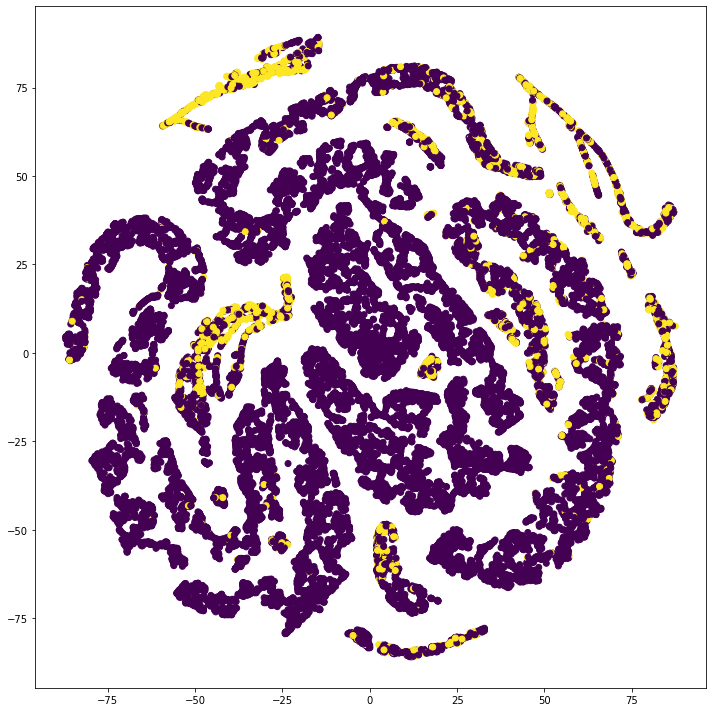

In [20]:
tsne = TSNE ( n_components = 2 , random_state = 37 , perplexity = 30 )
tsne_data = tsne.fit_transform ( X_train ) 
plt.figure ( figsize = ( 10 , 10 ) )
plt.scatter ( tsne_data [ : , 0 ] , tsne_data [ : , 1 ] , c = y_train.values )
plt.show ( )

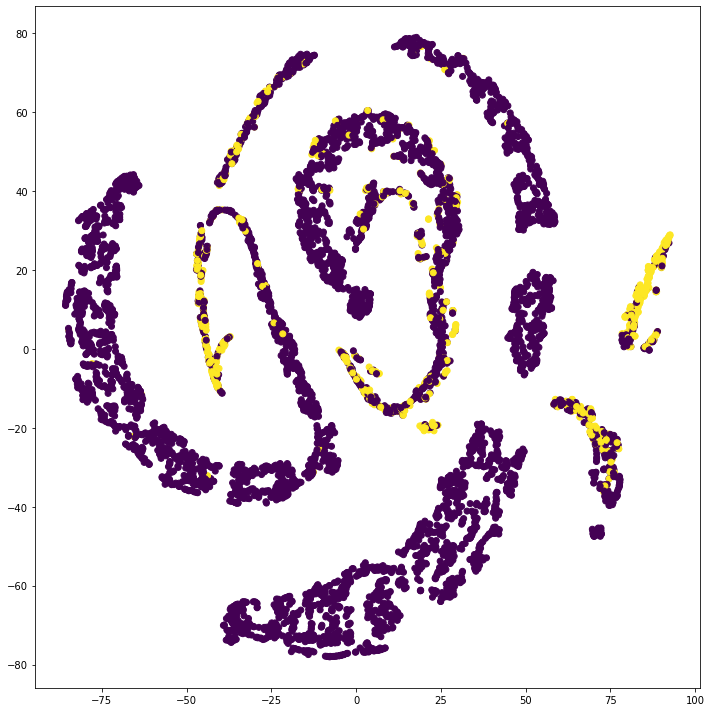

In [21]:
tsne = TSNE ( n_components = 2 , random_state = 37 , perplexity = 30 )
tsne_data = tsne.fit_transform ( X_valid ) 
plt.figure ( figsize = ( 10 , 10 ) )
plt.scatter ( tsne_data [ : , 0 ] , tsne_data [ : , 1 ] , c = y_valid.values )
plt.show ( )

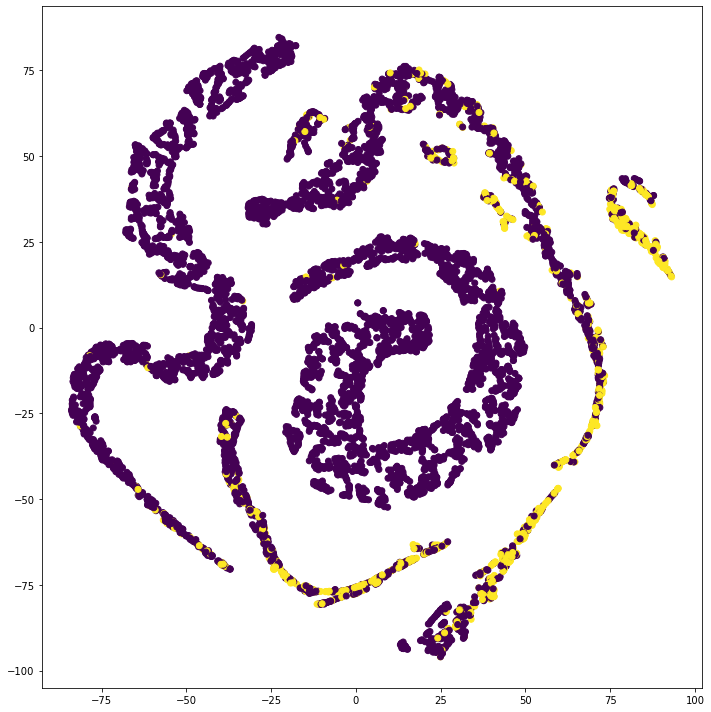

In [22]:
tsne = TSNE ( n_components = 2 , random_state = 37 , perplexity = 30 )
tsne_data = tsne.fit_transform ( X_test ) 
plt.figure ( figsize = ( 10 , 10 ) )
plt.scatter ( tsne_data [ : , 0 ] , tsne_data [ : , 1 ] , c = y_test.values )
plt.show ( )

### Logistic Regression Model

In [23]:
model = LogisticRegression ( class_weight='balanced' )
model.fit ( X_train , y_train )
y_pred = model.predict_proba ( X_test ) 

print ( "AUC score with duration: ", roc_auc_score ( y_test, y_pred [ : , 1 ] ) )

AUC score with duration:  0.9345723109114925


### Removing the duration variabe since it's a direct predictor of our target variable

In [24]:
X_train.drop ( "duration" , axis = 1 , inplace = True )
X_test.drop ( "duration" , axis = 1 , inplace = True )
X_valid.drop ( "duration" , axis = 1 , inplace = True )

print ( "X_train:" , X_train.shape )
print ( "X_test:" , X_test.shape )
print ( "X_valid:" , X_valid.shape )

X_train: (26360, 62)
X_test: (8238, 62)
X_valid: (6590, 62)


### Visualizing t-SNE again without duration

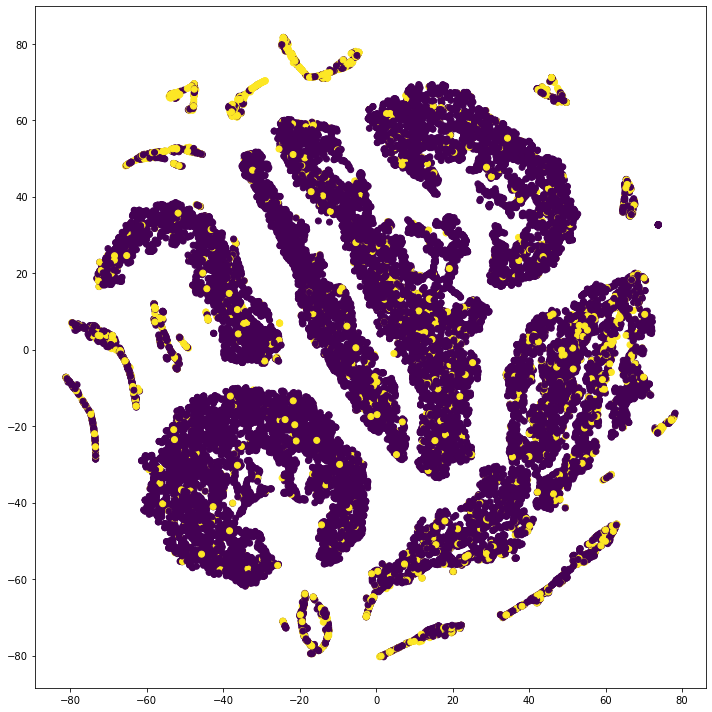

In [25]:
tsne = TSNE ( n_components = 2 , random_state = 37 , perplexity = 30 )
tsne_data = tsne.fit_transform ( X_train ) 
plt.figure ( figsize = ( 10 , 10 ) )
plt.scatter ( tsne_data [ : , 0 ] , tsne_data [ : , 1 ] , c = y_train.values )
plt.show ( )

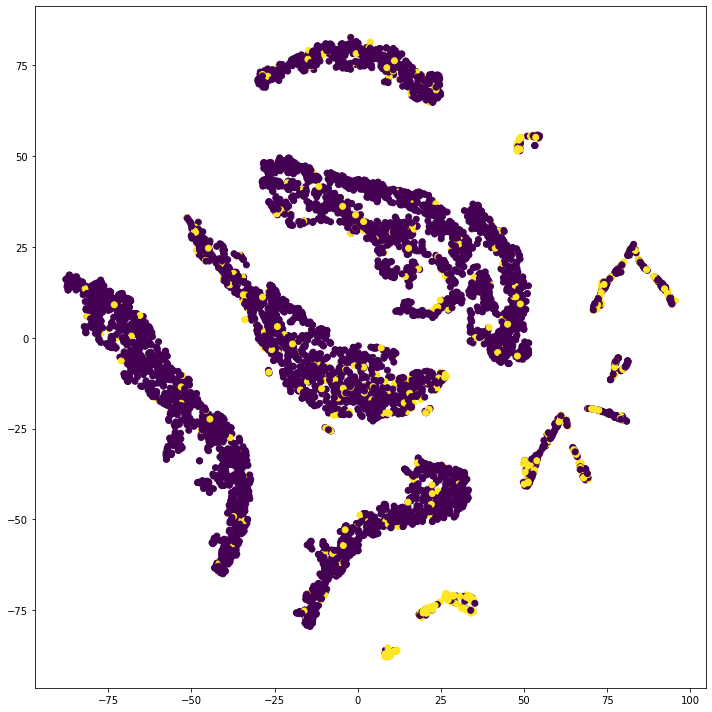

In [26]:
tsne = TSNE ( n_components = 2 , random_state = 37 , perplexity = 30 )
tsne_data = tsne.fit_transform ( X_valid ) 
plt.figure ( figsize = ( 10 , 10 ) )
plt.scatter ( tsne_data [ : , 0 ] , tsne_data [ : , 1 ] , c = y_valid.values )
plt.show ( )

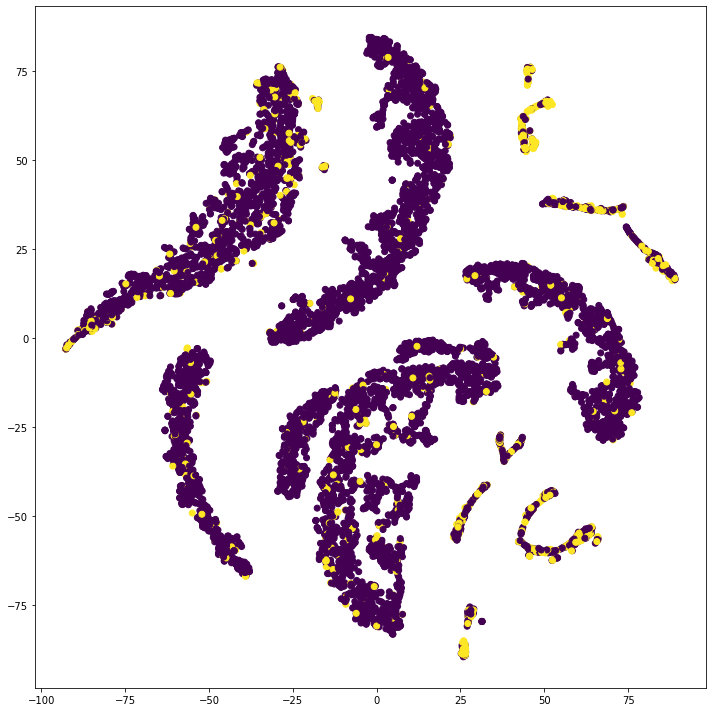

In [27]:
tsne = TSNE ( n_components = 2 , random_state = 37 , perplexity = 30 )
tsne_data = tsne.fit_transform ( X_test ) 
plt.figure ( figsize = ( 10 , 10 ) )
plt.scatter ( tsne_data [ : , 0 ] , tsne_data [ : , 1 ] , c = y_test.values )
plt.show ( )

### Logistic Regression Model with and without Class weight balancing

In [28]:
model = LogisticRegression ( class_weight='balanced' )
model.fit ( X_train , y_train )
y_pred = model.predict_proba ( X_test ) 

print ( "AUC score with duration: ", roc_auc_score ( y_test, y_pred [ : , 1 ] ) )

AUC score with duration:  0.789567869861552


In [29]:
model = LogisticRegression ( )
model.fit ( X_train , y_train )
y_pred = model.predict_proba ( X_test ) 

print ( "AUC score with duration: ", roc_auc_score ( y_test, y_pred [ : , 1 ] ) )

AUC score with duration:  0.7824047530648104


### K-Nearest Neighbors

The AUC for k=1 is: 0.6740075286955407
The AUC for k=3 is: 0.7170579662123163
The AUC for k=5 is: 0.7429921034669992
The AUC for k=7 is: 0.7494698511250284
The AUC for k=9 is: 0.7584568979101679
The AUC for k=11 is: 0.758813675161439
The AUC for k=13 is: 0.76275783684208
The AUC for k=15 is: 0.7653995164066226
The AUC for k=17 is: 0.7643834594919283
The AUC for k=19 is: 0.7668733747479242


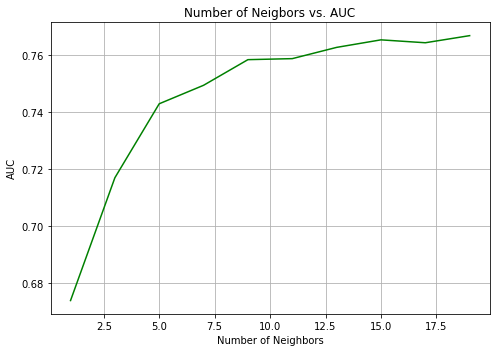

For the best value of k=19, the AUC for train data is: 0.8568512358512359
For the best value of k=19, the AUC for test data is: 0.7855502329065968
For the best value of k=19, the AUC for validation data is: 0.7668733747479242


In [35]:
neighbors = [ x for x in range ( 1 , 20 , 2 ) ]
auc_score = [ ]
for i in neighbors:
    knn = KNeighborsClassifier ( n_neighbors = i )
    knn.fit ( X_train , y_train )
    cccv = CalibratedClassifierCV ( knn , method = "sigmoid" )
    cccv.fit ( X_train , y_train )
    y_pred = cccv.predict_proba ( X_valid )
    auc_score.append ( roc_auc_score ( y_valid , y_pred [ : , 1 ] ) )

for i in range ( len ( auc_score ) ):
    print ( "The AUC for k={} is: {}" .format ( neighbors [ i ] , auc_score [ i ] ) )

plt.plot ( neighbors , auc_score , color = "g" )
plt.title ( "Number of Neigbors vs. AUC" )
plt.xlabel ( "Number of Neighbors" )
plt.ylabel ( "AUC" )
plt.grid ( True )
plt.show ( )

knn = KNeighborsClassifier ( n_neighbors = neighbors [ np.argmax ( auc_score ) ] )
knn.fit ( X_train , y_train )
cccv = CalibratedClassifierCV ( knn , method = "sigmoid" )
cccv.fit ( X_train , y_train )

y_pred_train = cccv.predict_proba ( X_train )
y_pred_test = cccv.predict_proba ( X_test )
y_pred_valid = cccv.predict_proba ( X_valid )

print ( "For the best value of k={}, the AUC for train data is: {}" .format ( neighbors [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_train , y_pred_train [ : , 1 ] ) ) )
print ( "For the best value of k={}, the AUC for test data is: {}" .format ( neighbors [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_test , y_pred_test [ : , 1 ] ) ) )
print ( "For the best value of k={}, the AUC for validation data is: {}" .format ( neighbors [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_valid , y_pred_valid [ : , 1 ] ) ) )

### Logistic Regression

The AUC for C=1e-05 is: 0.7648596185847083
The AUC for C=0.0001 is: 0.7728133910166931
The AUC for C=0.001 is: 0.7900684569914089
The AUC for C=0.01 is: 0.7933140011525422
The AUC for C=0.1 is: 0.7921210949196242
The AUC for C=1 is: 0.7935253993704575
The AUC for C=10 is: 0.7937527607763492
The AUC for C=100 is: 0.790849056883452
The AUC for C=1000 is: 0.7947267432884486


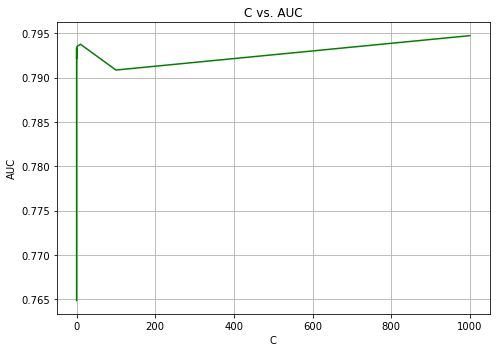

For the best value of C=1000, the AUC for train data is: 0.7788111861861862
For the best value of C=1000, the AUC for test data is: 0.7802555823872569
For the best value of C=1000, the AUC for validation data is: 0.7865378559021264


In [34]:
c = [ 10 ** i for i in range ( -5 , 4 ) ]
auc_score = [ ]
for i in c:
    lr = LogisticRegression ( penalty = "l2" , C = i , class_weight = "balanced" )
    lr.fit ( X_train , y_train )
    cccv = CalibratedClassifierCV ( lr , method = "sigmoid" )
    cccv.fit ( X_train , y_train )
    y_pred = cccv.predict_proba ( X_valid )
    auc_score.append ( roc_auc_score ( y_valid , y_pred [ : , 1 ] ) )

for i in range ( len ( auc_score ) ):
    print ( "The AUC for C={} is: {}" .format ( c [ i ] , auc_score [ i ] ) )

plt.plot ( c , auc_score , color = "g" )
plt.title ( "C vs. AUC" )
plt.xlabel ( "C" )
plt.ylabel ( "AUC" )
plt.grid ( True )
plt.show ( )

lr = LogisticRegression ( C = c [ np.argmax ( auc_score ) ] )
lr.fit ( X_train , y_train )
cccv = CalibratedClassifierCV ( lr , method = "sigmoid" )
cccv.fit ( X_train , y_train )

y_pred_train = cccv.predict_proba ( X_train )
y_pred_test = cccv.predict_proba ( X_test )
y_pred_valid = cccv.predict_proba ( X_valid )

print ( "For the best value of C={}, the AUC for train data is: {}" .format ( c [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_train , y_pred_train [ : , 1 ] ) ) )
print ( "For the best value of C={}, the AUC for test data is: {}" .format ( c [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_test , y_pred_test [ : , 1 ] ) ) )
print ( "For the best value of C={}, the AUC for validation data is: {}" .format ( c [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_valid , y_pred_valid [ : , 1 ] ) ) )


The AUC wioth n_estimators=10 is: 0.780002070653526
The AUC wioth n_estimators=50 is: 0.7839789568695184
The AUC wioth n_estimators=100 is: 0.784195258066598
The AUC wioth n_estimators=500 is: 0.7841757601727125
The AUC wioth n_estimators=1000 is: 0.7845807690562266
The AUC wioth n_estimators=2000 is: 0.7848451878627777
The AUC wioth n_estimators=3000 is: 0.7850017411277171


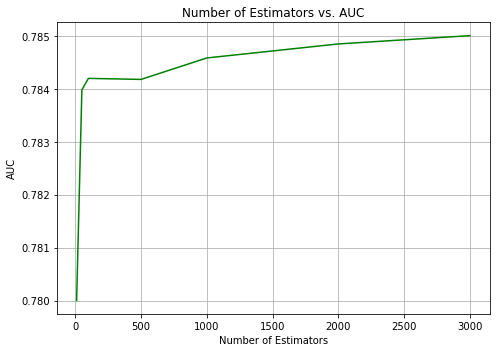

For the best value with n_estimators=3000, the AUC for train data is: 0.999767223954724
For the best value with n_estimators=3000, the AUC for test data is: 0.7870916034480397
For the best value with n_estimators=3000, the AUC for validation data is: 0.7853531593087393


In [38]:
estimators = [ 10 , 50 , 100 , 500 , 1000 , 2000 , 3000 ]
auc_score = [ ]
for i in estimators:
    rfc = RandomForestClassifier ( n_estimators = i , random_state = 37 , n_jobs = -1 )
    rfc.fit ( X_train , y_train )
    cccv = CalibratedClassifierCV ( rfc , method = "sigmoid" )
    cccv.fit ( X_train , y_train )
    y_pred = cccv.predict_proba ( X_valid )
    auc_score.append ( roc_auc_score ( y_valid , y_pred [ : , 1 ] ) )

for i in range ( len ( auc_score ) ):
    print ( "The AUC with n_estimators={} is: {}" .format ( estimators [ i ] , auc_score [ i ] ) )

plt.plot ( estimators , auc_score , color = "g" )
plt.title ( "Number of Estimators vs. AUC" )
plt.xlabel ( "Number of Estimators" )
plt.ylabel ( "AUC" )
plt.grid ( True )
plt.show ( )

lr = RandomForestClassifier ( n_estimators = estimators [ np.argmax ( auc_score ) ] )
lr.fit ( X_train , y_train )
cccv = CalibratedClassifierCV ( lr , method = "sigmoid" )
cccv.fit ( X_train , y_train )

y_pred_train = cccv.predict_proba ( X_train )
y_pred_test = cccv.predict_proba ( X_test )
y_pred_valid = cccv.predict_proba ( X_valid )

print ( "For the best value with n_estimators={}, the AUC for train data is: {}" .format ( estimators [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_train , y_pred_train [ : , 1 ] ) ) )
print ( "For the best value with n_estimators={}, the AUC for test data is: {}" .format ( estimators [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_test , y_pred_test [ : , 1 ] ) ) )
print ( "For the best value with n_estimators={}, the AUC for validation data is: {}" .format ( estimators [ np.argmax ( auc_score ) ] , \
    roc_auc_score ( y_valid , y_pred_valid [ : , 1 ] ) ) )